# Transfomer(年齢予測)

## import ライブラリー

In [1]:
"""%%bash
python3 -m pip install --user torch
python3 -m pip install --user scikit-learn"""

'%%bash\npython3 -m pip install --user torch\npython3 -m pip install --user scikit-learn'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from scipy.stats import pearsonr

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.device_count()
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

4

In [3]:
device

device(type='cuda')

## Data定義

In [4]:
%%time
#6分ぐらいかかる
df_aal = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_aal.csv')
df_ho = pd.read_csv('../02_data_analysis/roi_timeseries/timeseries_ho.csv')

#df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
#df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')

df_subjects_info = pd.read_csv('../02_data_analysis/subjects_info/subjects_info.csv')

CPU times: user 3.23 s, sys: 159 ms, total: 3.39 s
Wall time: 3.41 s


In [5]:
def make_info_data(df = df_subjects_info,col = ['Age','Sex','やる気スコア(Apathy scale)']):
    subID = np.array(df.subID)
    subjects_info_list = []
    for ID in subID:
        data = np.array(df[df.subID == ID][col])[0]
        if 'Sex' in col:
            idx_sex = col.index('Sex')
            if data[idx_sex] == '男':
                data[idx_sex] = 0
            else:
                data[idx_sex] = 1
        
        subjects_info_list.append(data)
    subjects_info = np.array(subjects_info_list)
    
    if 'Age' in col:
        idx_age = col.index('Age')
    for i in range(len(col)):
        if i == idx_age:
            subjects_info[:,i] = (subjects_info[:,i] - \
                                  np.mean(subjects_info[:,i]))/np.std(subjects_info[:,i])
    return subjects_info.astype(np.float)

def make_data(df, subID = df_subjects_info.subID ,remove_list = ['time','subID']):
    data_list = []
    df_cols = list(df.columns)
    for r in remove_list:
        try:
            df_cols.remove(r)
        except:
            pass
    for ID in df_subjects_info.subID:
        data = df[df.subID == ID][df_cols]
        data = np.array(data)
        data_list.append(data)
    data = np.array(data_list)
    return data

In [6]:
%%time
data_label = make_info_data()
data_aal = make_data(df_aal)
data_ho = make_data(df_ho)

age_mean = df_subjects_info.Age.mean()
age_std = df_subjects_info.Age.std()

CPU times: user 10.1 s, sys: 34.8 ms, total: 10.1 s
Wall time: 10.1 s


In [7]:
data_label.shape
data_aal.shape
data_ho.shape

(615, 3)

(615, 140, 116)

(615, 140, 110)

In [8]:
#30秒ぐらいかかる
#data_dynamic_aal = make_data(df_dynamic_aal)
#data_dynamic_ho = make_data(df_dynamic_ho)

#data_dynamic_aal.shape
#data_dynamic_ho.shape

## Model作成

In [9]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout)
        # Not a parameter
        self.register_buffer('pe', self._pe_table(d_model, max_len))

    def _pe_table(self, d_model: int, max_len: int) -> torch.Tensor:
        pos = torch.arange(0, max_len).unsqueeze(1)
        pe_denominator = torch.exp(
            torch.arange(0, d_model, 2) * math.log(10000) / d_model
        )

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos / pe_denominator)  # 偶数項にはsin
        pe[:, 1::2] = torch.cos(pos / pe_denominator)  # 奇数項にはcos

        pe = pe.unsqueeze(0)  # バッチに対応するため
        return pe

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)].clone().detach())

In [10]:
class Model(nn.Module):    
    def __init__(self,
                 input_dim,
                 d_model,
                 hidden_dim,
                 time_len,
                 nhead,
                 output_dim,
                 hidden_dim_transformer,
                 pos_drop,
                 trans_drop,
                 fc_drop
                ):
        super(Model, self).__init__()
        self.fc0  = nn.Linear(input_dim,d_model)
        self.pos  = PositionalEncoding(d_model = d_model,dropout=pos_drop)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                                    nhead,
                                                                    dropout=trans_drop,
                                                                    dim_feedforward=hidden_dim,
                                                                    batch_first=True)
        self.transformer_encoder       = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                               num_layers=hidden_dim_transformer)
        self.fc1  = nn.Linear(d_model,1)
        self.fc2  = nn.Linear(time_len,1)
        self.drop  = nn.Dropout(fc_drop)
        self.time_len = time_len
        
    def forward(self,x):
        x = self.fc0(x)
        x = self.pos(x)
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = torch.reshape(x, (-1, self.time_len))
        x = self.fc2(x)
        return x

In [11]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label=None):
        self.data = data
        self.label = label
        self.test = label is None
        self.length = data.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self,idx):
        if self.test:
            data = torch.tensor(self.data[idx])
            return data
        else:
            data = torch.tensor(self.data[idx])
            label = torch.tensor(self.label[idx])
            return data, label

In [12]:
def compute_loss(y, t):
    criterion = nn.MSELoss()
    return criterion(y, t)

def train_step(x,t,model,optimizer):
    model.train()
    preds = model(x)
    loss = compute_loss(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds

def val_step(x,t,model):
    model.eval()
    preds = model(x)
    loss = compute_loss(preds, t)    
    return loss, preds

def test_step(x,model):
    model.eval()
    preds = model(x)
    return preds

def seed_worker(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [13]:
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0, mode='loss'):
        self._step = 0
        self.patience = patience
        self.verbose = verbose
        
        self.mode = mode
        
        if self.mode == 'loss':
            self._loss = float('inf')
        elif self.mode == 'score':
            self._score = 0.
        else:
            raise Exception('error')

    def __call__(self, value):
        if self.mode == 'loss':
            if self._loss < value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._loss = value

            return False
        
        elif self.mode == 'score':
            if self._score > value:
                self._step += 1
                if self._step > self.patience:
                    if self.verbose:
                        print('early stopping')
                    return True
            else:
                self._step = 0
                self._score = value

            return False

In [14]:
def train_model(data,
                label,
                train_idx,
                test_idx,
                n_splits,
                epochs     = 750,
                d_model    = 128,
                hidden_dim = 512,
                nhead      = 32,
                hidden_dim_transformer = 2,
                pos_drop    = 0.1,
                trans_drop = 0.1,
                fc_drop = 0.1,
                title = ''
                ):
    
    epochs = epochs
    seed_worker()
    label = np.array([label[:,0]]).T
    
    train_all = data[train_idx]
    test  = data[test_idx]
    
    train_label_all = label[train_idx]
    test_label  = label[test_idx]
    
    input_dim  = data.shape[2]
    time_len   = data.shape[1]
    output_dim = data_label.shape[1]
    d_model    = d_model
    hidden_dim = hidden_dim
    nhead      = nhead
    hidden_dim_transformer = hidden_dim_transformer
    pos_drop    = pos_drop
    trans_drop = trans_drop
    fc_drop = fc_drop
    
    test_dataset = MyDataset(test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32)
    
    kf = KFold(n_splits=n_splits,shuffle=False)
    test_pred_all = []
    test_pred_all_corrected = []
    
    model_path = '../02_data_analysis/model/model_.pth'

    if torch.cuda.device_count() > 1:
        batch_size = 32 * torch.cuda.device_count()
    else:
        batch_size = 32
    
    for n_fold, (train_index, val_index) in enumerate(kf.split(train_all)):
        save_epochs = 0
        train_loss_plot = []
        val_loss_plot = []
        
        train, train_label = train_all[train_index], train_label_all[train_index]
        val,   val_label   = train_all[val_index],   train_label_all[val_index]
        
        train_dataset    = MyDataset(train,train_label)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

        val_dataset      = MyDataset(val,val_label)
        val_dataloader   = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size)
        
        model = Model(input_dim = input_dim,
                      d_model  = d_model,
                      hidden_dim = hidden_dim,
                      time_len = time_len,
                      nhead = nhead,
                      output_dim = output_dim,
                      hidden_dim_transformer = hidden_dim_transformer,
                      pos_drop = pos_drop,
                      trans_drop = trans_drop,
                      fc_drop = fc_drop
                     )
        
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
            model = nn.DataParallel(model)

        model.to(device)

        
        optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
        
        es = EarlyStopping(patience=200, verbose=1, mode='loss')
        best_val_loss = 1e5
        
        for epoch in range(epochs):
            train_loss = 0.
            val_loss = 0.

            for (x, t) in train_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = train_step(x,t,model,optimizer)
                train_loss += loss.item()
            train_loss /= len(train_dataloader)
            
            for (x, t) in val_dataloader:
                x, t = x.to(device), t.to(device)
                x = x.float()
                t = t.float()
                loss, preds = val_step(x,t,model)
                val_loss += loss.item()
            val_loss /= len(val_dataloader)
            
            if (epoch+1) % 100 == 0:
                print(f'Kfold: {n_fold+1} ::: epoch: {epoch+1}, loss: {train_loss}, val loss: {val_loss}')
                
            #early stopping
            if epoch <=200:
                pass
            elif es(val_loss):
                break

            # modelの保存
            if epoch <=200:
                pass
            elif val_loss < best_val_loss:
                save_epochs = epoch+1
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_path)
        
            train_loss_plot.append(train_loss)
            val_loss_plot.append(val_loss)
        
        model.load_state_dict(torch.load(model_path))
        print(f'save_epochs:{save_epochs}')
        print(f'best val loss:{best_val_loss}')
        
        train_loss_plot = np.array(train_loss_plot)
        val_loss_plot   = np.array(val_loss_plot)
        x               = np.linspace(0, len(train_loss_plot), len(train_loss_plot))
        
        plt.figure(figsize=(6, 4), dpi=80)
        plt.plot(x, train_loss_plot, label="train loss")
        plt.plot(x, val_loss_plot, label="val loss")
        plt.title('Loss Curves' + ' ' + title, fontsize=14)   # 図のタイトル
        plt.xlabel('Epochs',fontsize=14) # x軸のラベル
        plt.ylabel('MSELoss',fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        
        train_pred = []
        train_label = []
        
        for (x, t) in train_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t,model)
            train_pred.append(preds)
            train_label.append(t)
        
        val_pred = []
        for (x, t) in val_dataloader:
            x, t = x.to(device), t.to(device)
            x = x.float()
            t = t.float()
            loss, preds = val_step(x,t,model)
            val_pred.append(preds)
        
        train_pred = torch.cat(train_pred)
        train_pred = train_pred.to('cpu').detach().numpy().copy()
        
        train_label = torch.cat(train_label)
        train_label = train_label.to('cpu').detach().numpy().copy()
        
        val_pred = torch.cat(val_pred)
        val_pred = val_pred.to('cpu').detach().numpy().copy()
        
        new_line = '\n'
        
        corr,p = pearsonr(train_label[:,0],np.array(train_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((train_label[:,0]*age_std)+age_mean,(np.array(train_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter train', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 train data: ', r2_score(train_label[:,0],np.array(train_pred[:,0])))
        
        corr,p = pearsonr(val_label[:,0],np.array(val_pred[:,0]))
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter((val_label[:,0]*age_std)+age_mean,(np.array(val_pred[:,0])*age_std)+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')
        plt.title(title + ' ' + 'scatter val', fontsize=14)   # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()
        plt.show()
        print('r^2 val data: ', r2_score(val_label[:,0],np.array(val_pred[:,0])))
        
        lr = LinearRegression()
        lr.fit(val_label*age_std+age_mean,val_pred[:,0]*age_std+age_mean)
        
        plt.figure(figsize=(6, 6), dpi=80)
        plt.scatter(val_label[:,0]*age_std+age_mean,val_pred[:,0]*age_std+age_mean,
                   label = f'corrcoef : {corr:.3f}{new_line}p value : {p}')#散布図をプロット
        plt.plot(val_label[:,0]*age_std + age_mean,
                 lr.predict(val_label*age_std+age_mean), color = 'red',
                label = f'y = {lr.coef_[0]:.3f}x + {lr.intercept_:.3f}')#回帰直線をプロット
        
        plt.title(title + ' ' + 'val', fontsize=14)  # 図のタイトル
        plt.xlabel('chronological age', fontsize=14) # x軸のラベル
        plt.ylabel('predicted age', fontsize=14) # y軸のラベル
        plt.legend(fontsize=10.5)
        plt.grid()  # グリッド線を表示
        plt.show()  # 図の表示
        print('切片:', lr.intercept_)
        print('傾き:', lr.coef_[0])
                
        test_pred = []
        for x in test_dataloader:
            x = x.to(device)
            x = x.float()
            preds = test_step(x,model)
            test_pred.append(preds)
        test_pred = torch.cat(test_pred)
        test_pred = test_pred.to('cpu').detach().numpy().copy()
        test_pred_corrected = (test_pred - lr.intercept_/ lr.coef_[0])
        if lr.coef_[0] > 0.25:
            test_pred_all.append(test_pred)
            test_pred_all_corrected.append(test_pred_corrected)
        
    return np.array(test_pred_all),np.array(test_pred_all_corrected),test_label

In [15]:
n_splits = 5

## 学習(AAL)

### ROI 1

Nested Kfold ::: 1
Let's use 4 GPUs!
Kfold: 1 ::: epoch: 100, loss: 0.03982323408126831, val loss: 0.7379520609974861
Kfold: 1 ::: epoch: 200, loss: 0.028061622753739357, val loss: 0.6884383782744408
Kfold: 1 ::: epoch: 300, loss: 0.019287276941423234, val loss: 0.6508647799491882
Kfold: 1 ::: epoch: 400, loss: 0.01379880502533454, val loss: 0.6023219674825668
Kfold: 1 ::: epoch: 500, loss: 0.014418822140074693, val loss: 0.6076289266347885
Kfold: 1 ::: epoch: 600, loss: 0.008140152069525076, val loss: 0.6133331507444382
Kfold: 1 ::: epoch: 700, loss: 0.006982998510536093, val loss: 0.6220815926790237
Kfold: 1 ::: epoch: 800, loss: 0.0059690903514050524, val loss: 0.6011591702699661
Kfold: 1 ::: epoch: 900, loss: 0.005909699194419842, val loss: 0.6183888614177704
Kfold: 1 ::: epoch: 1000, loss: 0.006177742607318438, val loss: 0.5994919985532761
save_epochs:985
best val loss:0.5737489014863968


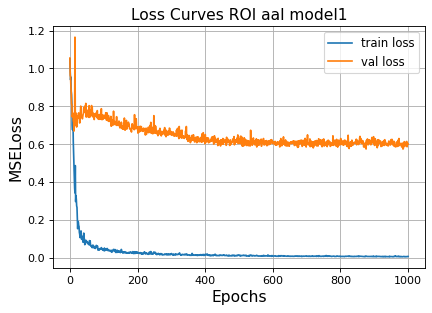

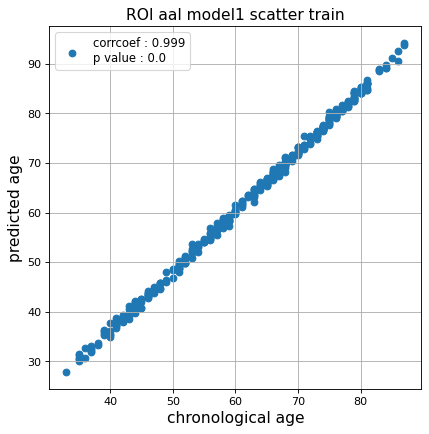

r^2 train data:  0.9502525316376003


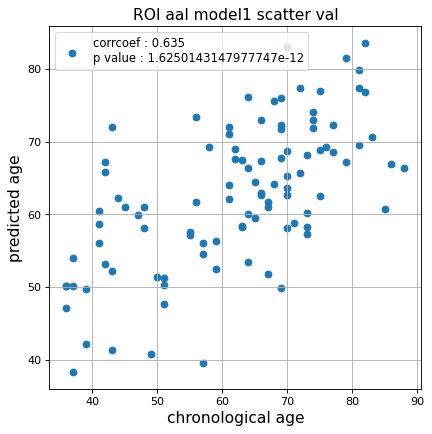

r^2 val data:  0.393321987604937


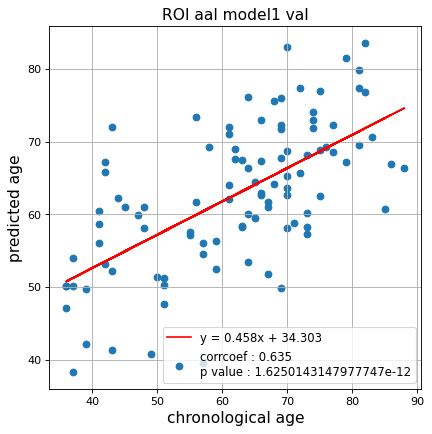

切片: 34.302965203875075
傾き: 0.45795875542733605
Let's use 4 GPUs!
Kfold: 2 ::: epoch: 100, loss: 0.036010129090685114, val loss: 0.5296419821679592
Kfold: 2 ::: epoch: 200, loss: 0.01805817436140317, val loss: 0.46315449476242065
Kfold: 2 ::: epoch: 300, loss: 0.014044328091236262, val loss: 0.44814397022128105
Kfold: 2 ::: epoch: 400, loss: 0.014338560474033538, val loss: 0.4191710874438286
Kfold: 2 ::: epoch: 500, loss: 0.009491551685361909, val loss: 0.39954642578959465
Kfold: 2 ::: epoch: 600, loss: 0.00934976783509438, val loss: 0.38718385621905327
Kfold: 2 ::: epoch: 700, loss: 0.0065399311088885255, val loss: 0.3744563367217779
Kfold: 2 ::: epoch: 800, loss: 0.006369883946787853, val loss: 0.35564275085926056
Kfold: 2 ::: epoch: 900, loss: 0.005903896911499592, val loss: 0.35146182775497437
Kfold: 2 ::: epoch: 1000, loss: 0.005522127263247967, val loss: 0.34272636100649834
save_epochs:938
best val loss:0.334039818495512


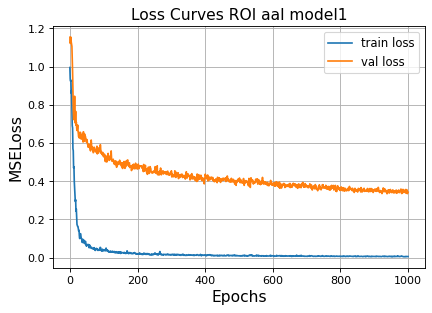

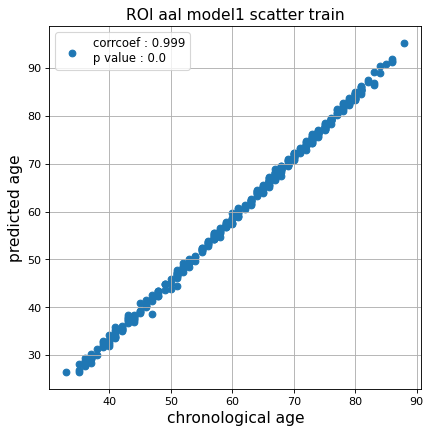

r^2 train data:  0.9171491630679738


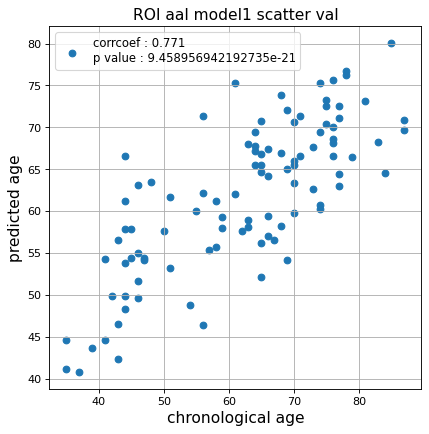

r^2 val data:  0.5827726439974055


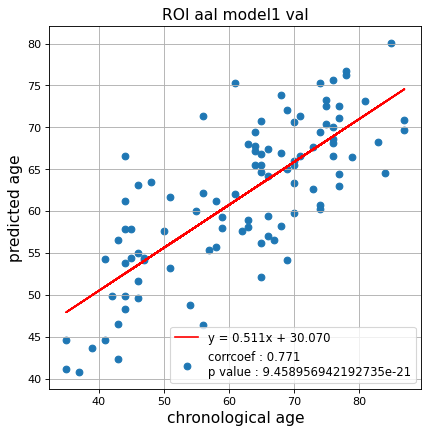

切片: 30.069887119110366
傾き: 0.5111987566684546
Let's use 4 GPUs!
Kfold: 3 ::: epoch: 100, loss: 0.036255983993984185, val loss: 0.5445159897208214
Kfold: 3 ::: epoch: 200, loss: 0.01926558006268281, val loss: 0.540840744972229
Kfold: 3 ::: epoch: 300, loss: 0.016309581338786162, val loss: 0.5228513926267624
Kfold: 3 ::: epoch: 400, loss: 0.013810324697540356, val loss: 0.5130172818899155
Kfold: 3 ::: epoch: 500, loss: 0.009125764302622814, val loss: 0.5148969739675522
early stopping
save_epochs:370
best val loss:0.4942164793610573


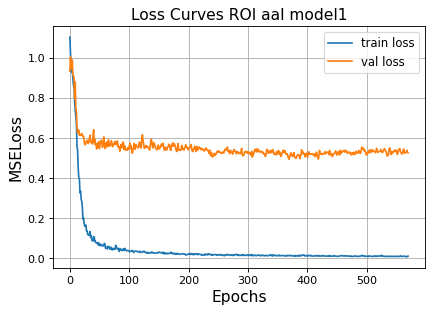

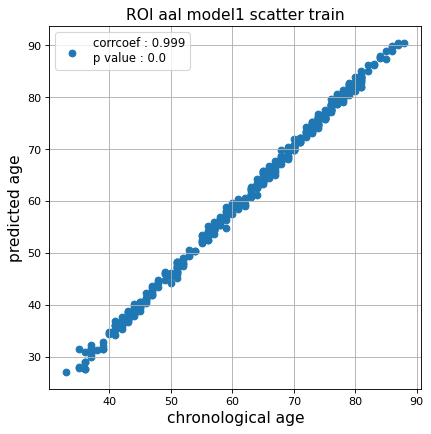

r^2 train data:  0.9458392022820719


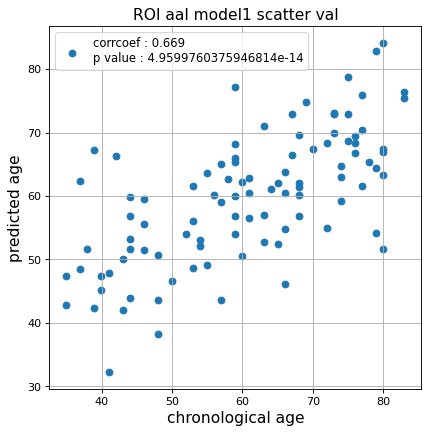

r^2 val data:  0.4362536235356316


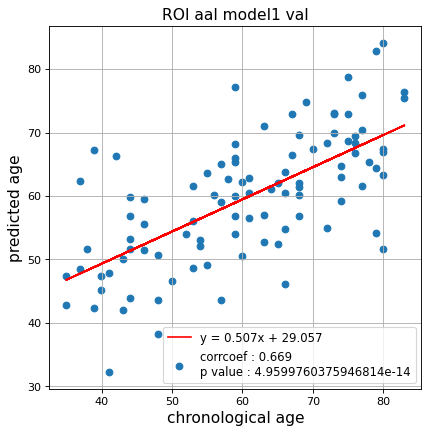

切片: 29.05678782272474
傾き: 0.5068791746227881
Let's use 4 GPUs!
Kfold: 4 ::: epoch: 100, loss: 0.04074818898852055, val loss: 0.9091920852661133
Kfold: 4 ::: epoch: 200, loss: 0.021078634434021436, val loss: 0.866508811712265
Kfold: 4 ::: epoch: 300, loss: 0.01691338448570325, val loss: 0.8056161999702454
Kfold: 4 ::: epoch: 400, loss: 0.012212974001438571, val loss: 0.8162650614976883
Kfold: 4 ::: epoch: 500, loss: 0.010524785683418695, val loss: 0.8309367299079895
early stopping
save_epochs:335
best val loss:0.7866485416889191


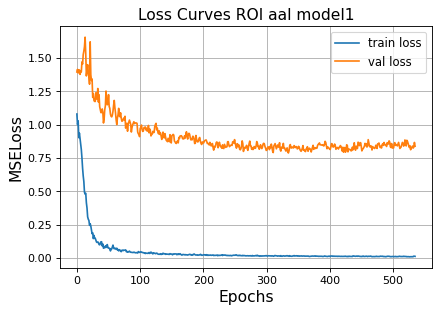

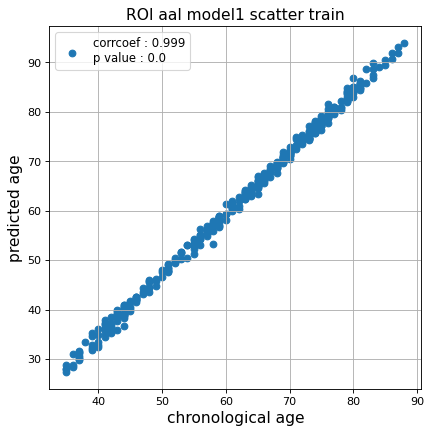

r^2 train data:  0.9394367440747082


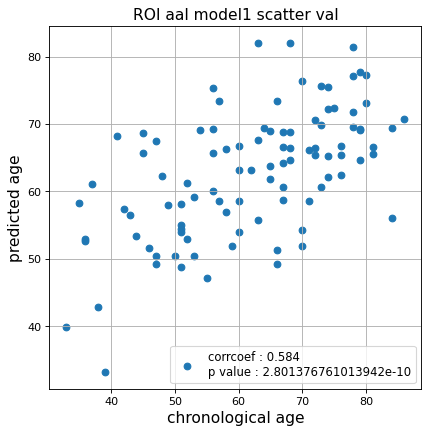

r^2 val data:  0.32371882783216654


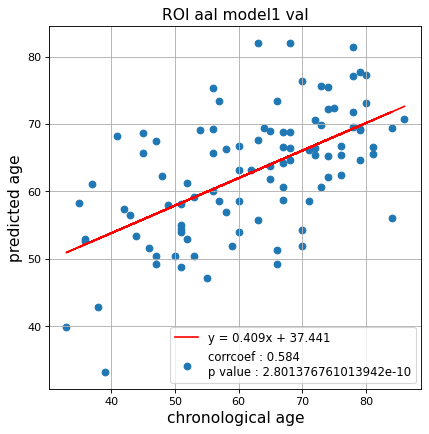

切片: 37.44057271474429
傾き: 0.409078856345808
Let's use 4 GPUs!
Kfold: 5 ::: epoch: 100, loss: 0.04346308040504272, val loss: 0.965703621506691
Kfold: 5 ::: epoch: 200, loss: 0.027998574651204623, val loss: 0.9161185473203659
Kfold: 5 ::: epoch: 300, loss: 0.01607754618789141, val loss: 0.8286567106842995
Kfold: 5 ::: epoch: 400, loss: 0.011468543026309747, val loss: 0.7933348417282104
Kfold: 5 ::: epoch: 500, loss: 0.012123649080212299, val loss: 0.7840484976768494
early stopping
save_epochs:388
best val loss:0.7560038566589355


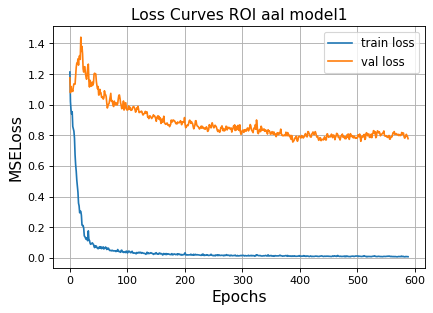

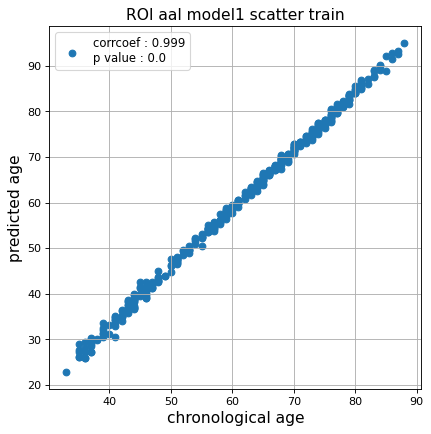

r^2 train data:  0.914480527943179


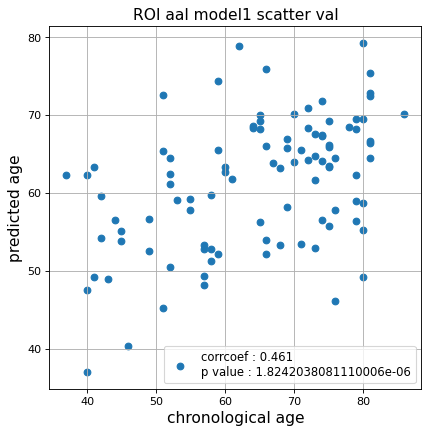

r^2 val data:  0.10781282671184145


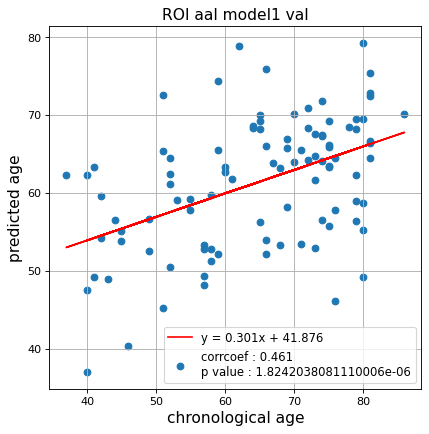

切片: 41.87575836031686
傾き: 0.3012816826806695
Nested Kfold ::: 2
Let's use 4 GPUs!
Kfold: 1 ::: epoch: 100, loss: 0.03938640811695503, val loss: 0.7241546809673309
Kfold: 1 ::: epoch: 200, loss: 0.02887628012551711, val loss: 0.7204088717699051
Kfold: 1 ::: epoch: 300, loss: 0.021420219626564246, val loss: 0.7606571614742279
Kfold: 1 ::: epoch: 400, loss: 0.014783227887864295, val loss: 0.6901834458112717
Kfold: 1 ::: epoch: 500, loss: 0.0122616569010111, val loss: 0.7152730971574783
Kfold: 1 ::: epoch: 600, loss: 0.007164247853394885, val loss: 0.6941356062889099
Kfold: 1 ::: epoch: 700, loss: 0.006432956890561259, val loss: 0.7050036787986755
Kfold: 1 ::: epoch: 800, loss: 0.006652229286443729, val loss: 0.6645438820123672
Kfold: 1 ::: epoch: 900, loss: 0.006478744558990002, val loss: 0.6965478956699371
Kfold: 1 ::: epoch: 1000, loss: 0.005858994984569458, val loss: 0.6558900699019432
save_epochs:838
best val loss:0.6473741382360458


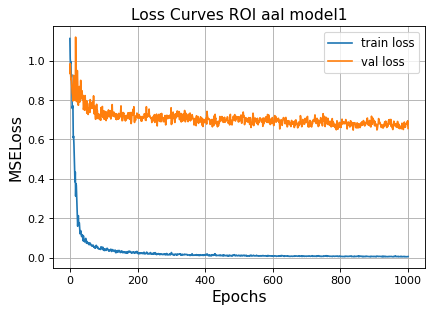

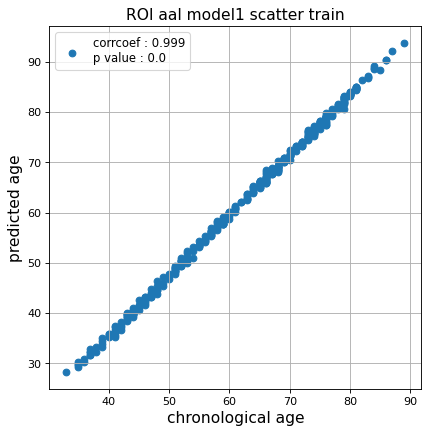

r^2 train data:  0.9578862621334088


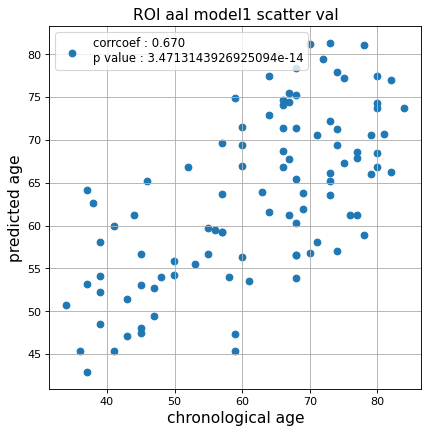

r^2 val data:  0.4370962139764357


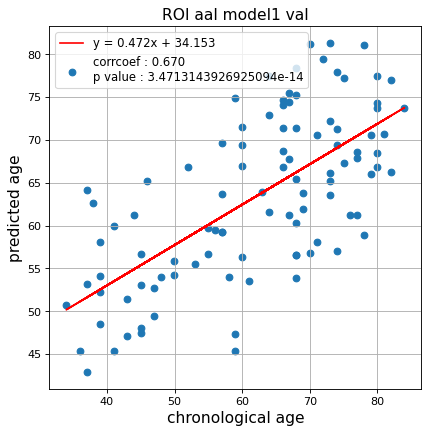

切片: 34.15329136992598
傾き: 0.47162647316972367
Let's use 4 GPUs!
Kfold: 2 ::: epoch: 100, loss: 0.03707095651099315, val loss: 0.7307988852262497
Kfold: 2 ::: epoch: 200, loss: 0.01910988535158909, val loss: 0.6776271164417267
Kfold: 2 ::: epoch: 300, loss: 0.017114986164065506, val loss: 0.6257796138525009
Kfold: 2 ::: epoch: 400, loss: 0.014207643456757069, val loss: 0.5632807910442352
Kfold: 2 ::: epoch: 500, loss: 0.00993049735776507, val loss: 0.5769451484084129
Kfold: 2 ::: epoch: 600, loss: 0.009307086539383117, val loss: 0.5798335745930672
Kfold: 2 ::: epoch: 700, loss: 0.007640558474052411, val loss: 0.5734755322337151
Kfold: 2 ::: epoch: 800, loss: 0.006852851141817295, val loss: 0.5676403194665909
Kfold: 2 ::: epoch: 900, loss: 0.0067230796871277, val loss: 0.5496416240930557
Kfold: 2 ::: epoch: 1000, loss: 0.004920087486075668, val loss: 0.5367430150508881
save_epochs:991
best val loss:0.5199947729706764


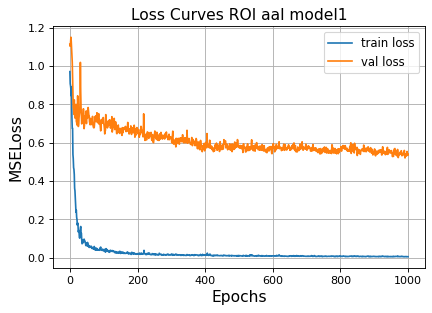

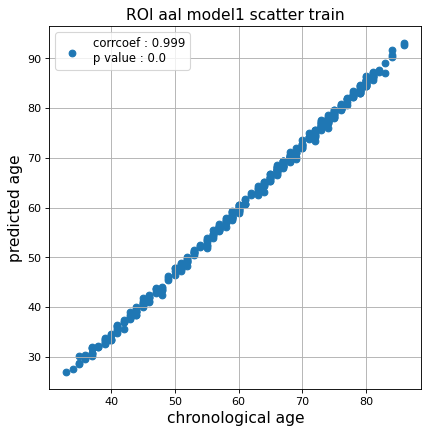

r^2 train data:  0.9251376010897879


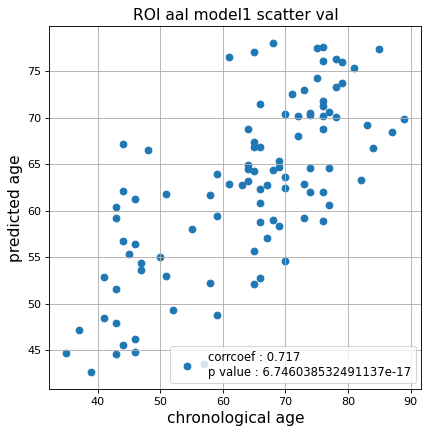

r^2 val data:  0.5041732515294364


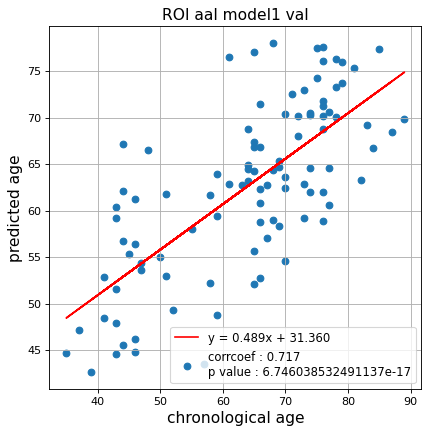

切片: 31.359671093200983
傾き: 0.4887838844455895
Let's use 4 GPUs!
Kfold: 3 ::: epoch: 100, loss: 0.034559421599484406, val loss: 0.5576166659593582
Kfold: 3 ::: epoch: 200, loss: 0.017770265945448324, val loss: 0.4905642531812191
Kfold: 3 ::: epoch: 300, loss: 0.015757226958297767, val loss: 0.47495178133249283
Kfold: 3 ::: epoch: 400, loss: 0.014563341410114216, val loss: 0.4613325670361519
Kfold: 3 ::: epoch: 500, loss: 0.01511083056147282, val loss: 0.4564683474600315
Kfold: 3 ::: epoch: 600, loss: 0.0072872493810092025, val loss: 0.4651103839278221
Kfold: 3 ::: epoch: 700, loss: 0.008450592294908486, val loss: 0.4523710533976555
Kfold: 3 ::: epoch: 800, loss: 0.00640711675469692, val loss: 0.4550827592611313
early stopping
save_epochs:618
best val loss:0.4320512190461159


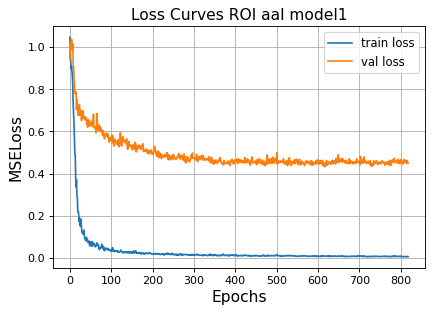

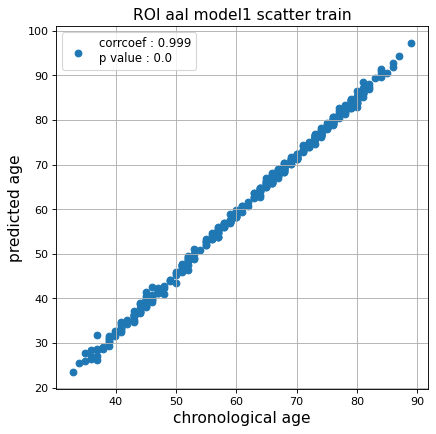

r^2 train data:  0.8977929221354426


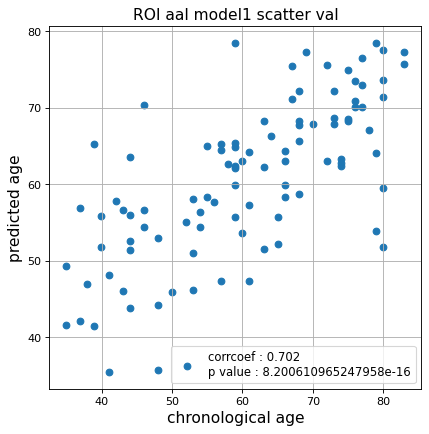

r^2 val data:  0.4899888279820942


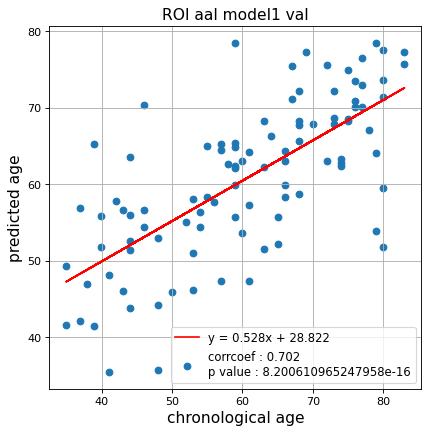

切片: 28.822036481521724
傾き: 0.5276032896084072
Let's use 4 GPUs!
Kfold: 4 ::: epoch: 100, loss: 0.03916127191713223, val loss: 1.5327410101890564
Kfold: 4 ::: epoch: 200, loss: 0.019404365967672605, val loss: 1.3826172202825546
Kfold: 4 ::: epoch: 300, loss: 0.013681427074166445, val loss: 1.3288014233112335
Kfold: 4 ::: epoch: 400, loss: 0.00989658901324639, val loss: 1.277378425002098
Kfold: 4 ::: epoch: 500, loss: 0.00887883031884065, val loss: 1.2812347263097763
Kfold: 4 ::: epoch: 600, loss: 0.009160695597529411, val loss: 1.2830711007118225
Kfold: 4 ::: epoch: 700, loss: 0.006543256557331636, val loss: 1.2338107824325562
Kfold: 4 ::: epoch: 800, loss: 0.006958996823344093, val loss: 1.2424304336309433
Kfold: 4 ::: epoch: 900, loss: 0.005181806896311732, val loss: 1.24555104970932
Kfold: 4 ::: epoch: 1000, loss: 0.0055833521048323466, val loss: 1.2273685038089752
save_epochs:802
best val loss:1.1802519708871841


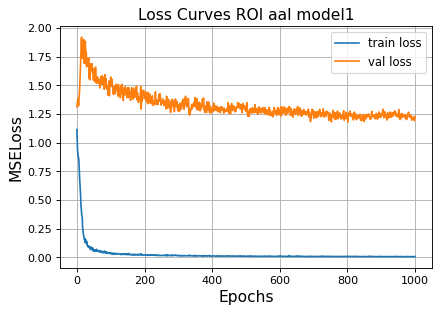

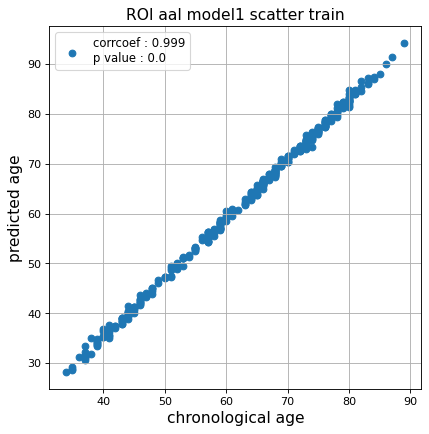

r^2 train data:  0.9610673267520178


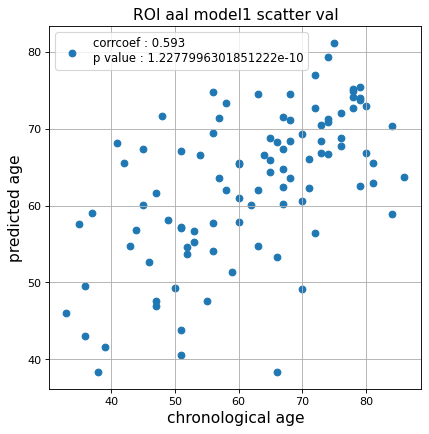

r^2 val data:  0.33207709096269566


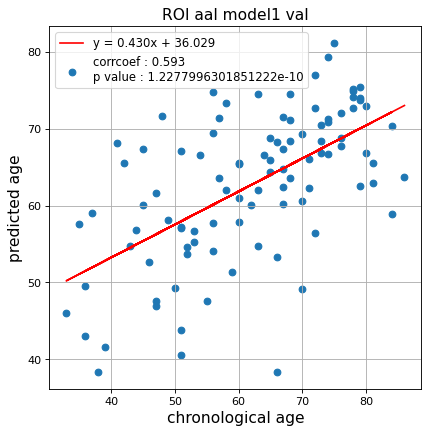

切片: 36.029108967049424
傾き: 0.4298989931727561
Let's use 4 GPUs!
Kfold: 5 ::: epoch: 100, loss: 0.04221657649255716, val loss: 0.7726312465965748
Kfold: 5 ::: epoch: 200, loss: 0.021685992295925435, val loss: 0.7547378055751324
Kfold: 5 ::: epoch: 300, loss: 0.015059907777378192, val loss: 0.7244342565536499
Kfold: 5 ::: epoch: 400, loss: 0.011205993736019501, val loss: 0.7046428993344307
Kfold: 5 ::: epoch: 500, loss: 0.010337231430010153, val loss: 0.6756111979484558
Kfold: 5 ::: epoch: 600, loss: 0.008154318381387454, val loss: 0.6644748598337173
Kfold: 5 ::: epoch: 700, loss: 0.00861312567184751, val loss: 0.6613761931657791
early stopping
save_epochs:582
best val loss:0.6516219675540924


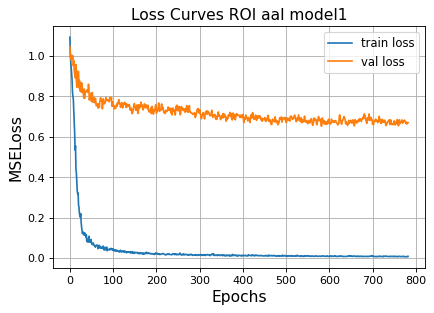

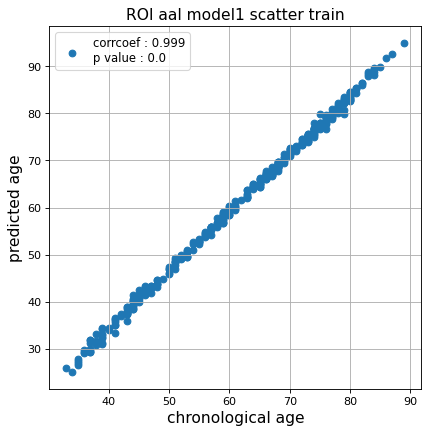

r^2 train data:  0.9407730261837967


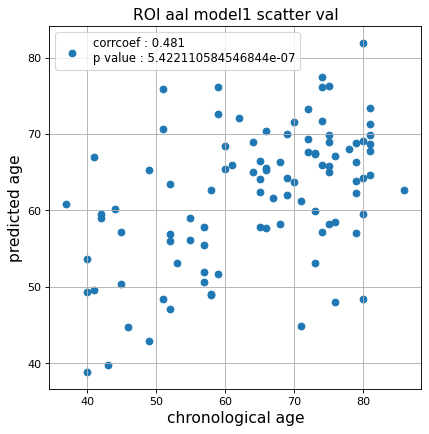

r^2 val data:  0.14094212818846308


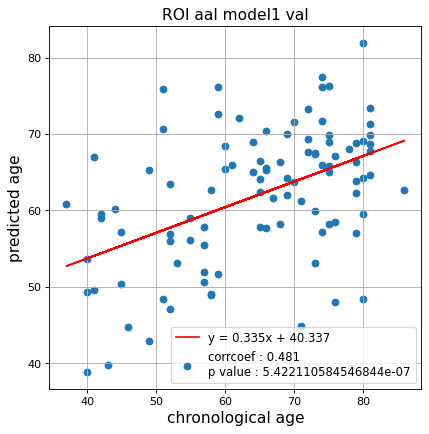

切片: 40.33655830757965
傾き: 0.33483452018278825
Nested Kfold ::: 3
Let's use 4 GPUs!
Kfold: 1 ::: epoch: 100, loss: 0.04631698360809913, val loss: 0.6802189201116562
Kfold: 1 ::: epoch: 200, loss: 0.02477848816376466, val loss: 0.6442717835307121
Kfold: 1 ::: epoch: 300, loss: 0.015940397153966702, val loss: 0.7077912986278534
Kfold: 1 ::: epoch: 400, loss: 0.012867015320807695, val loss: 0.6531505063176155
early stopping
save_epochs:252
best val loss:0.6216929107904434


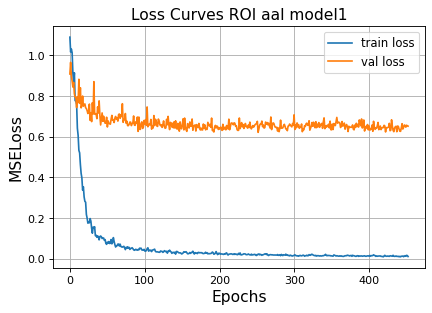

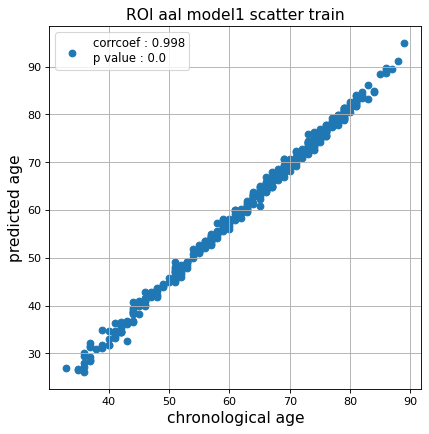

r^2 train data:  0.9313816572028278


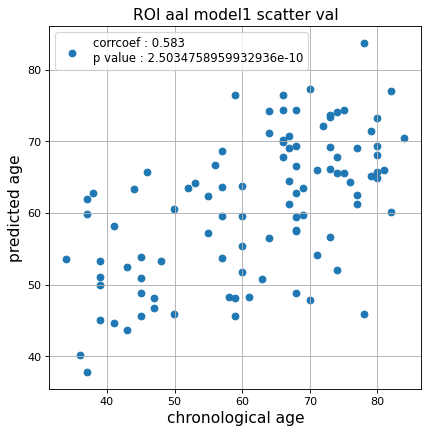

r^2 val data:  0.3157606370296132


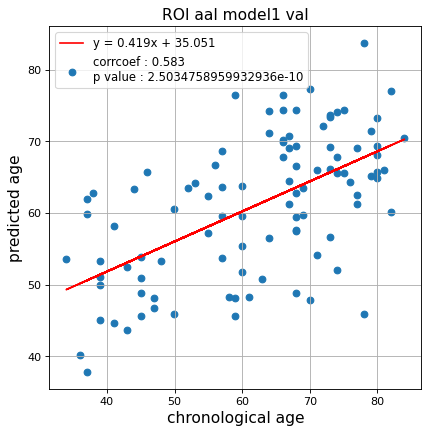

切片: 35.05060235025733
傾き: 0.41947672554536164
Let's use 4 GPUs!
Kfold: 2 ::: epoch: 100, loss: 0.06396883941040589, val loss: 0.757501594722271
Kfold: 2 ::: epoch: 200, loss: 0.022567518915121373, val loss: 0.666092362254858
Kfold: 2 ::: epoch: 300, loss: 0.015594597834234055, val loss: 0.6268923394382
Kfold: 2 ::: epoch: 400, loss: 0.014142605547721569, val loss: 0.5985675528645515
Kfold: 2 ::: epoch: 500, loss: 0.012950637091237765, val loss: 0.5729203466325998
Kfold: 2 ::: epoch: 600, loss: 0.009797775079138003, val loss: 0.5610399451106787
Kfold: 2 ::: epoch: 700, loss: 0.011718057991506962, val loss: 0.5577575629577041
Kfold: 2 ::: epoch: 800, loss: 0.007423446549532505, val loss: 0.5479542911052704
Kfold: 2 ::: epoch: 900, loss: 0.005818973796871992, val loss: 0.5458698235452175
Kfold: 2 ::: epoch: 1000, loss: 0.0054672576057223175, val loss: 0.5408863164484501
save_epochs:949
best val loss:0.5328184217214584


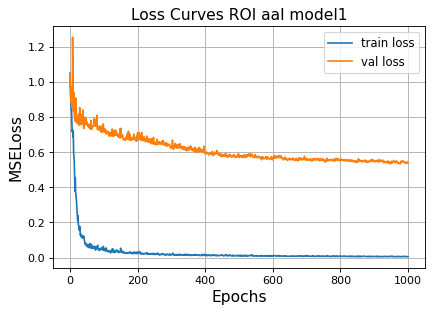

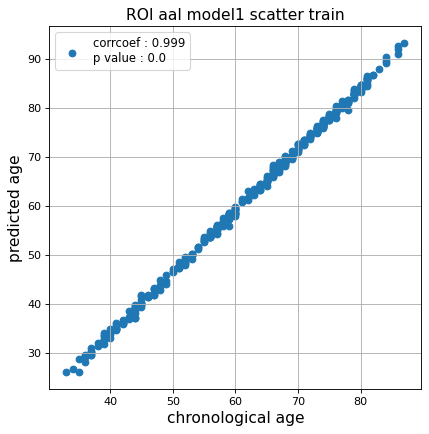

r^2 train data:  0.9311815108612038


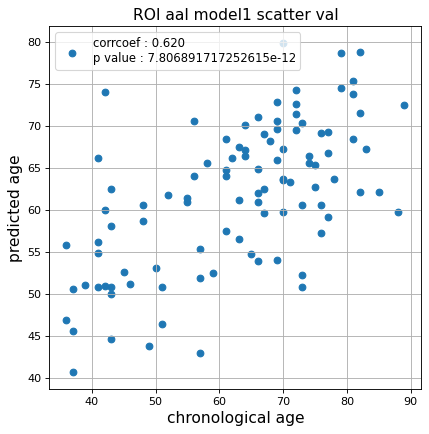

r^2 val data:  0.3802541864375927


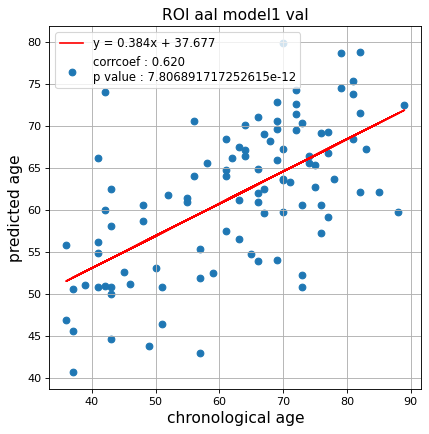

切片: 37.67677183989824
傾き: 0.3842179034237256
Let's use 4 GPUs!
Kfold: 3 ::: epoch: 100, loss: 0.0462700930925516, val loss: 0.6499741673469543
Kfold: 3 ::: epoch: 200, loss: 0.023062325512560513, val loss: 0.645049437880516
Kfold: 3 ::: epoch: 300, loss: 0.013700545980380131, val loss: 0.6686676889657974
Kfold: 3 ::: epoch: 400, loss: 0.01341827453758854, val loss: 0.6605308800935745
early stopping
save_epochs:213
best val loss:0.6222542375326157


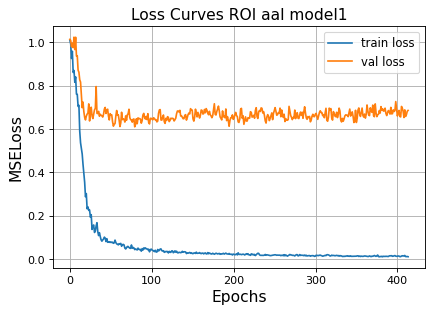

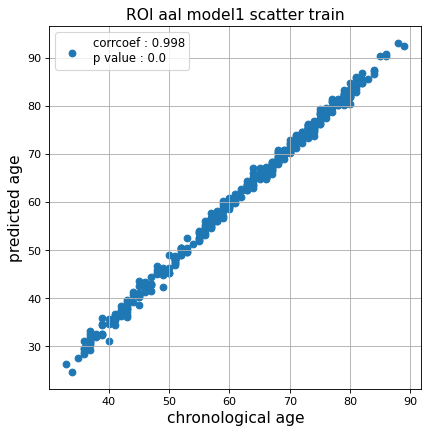

r^2 train data:  0.9490915245971012


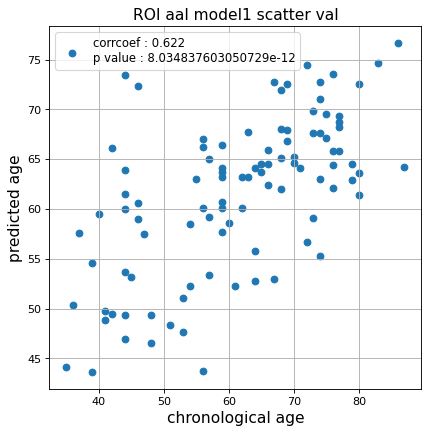

r^2 val data:  0.3861481282626119


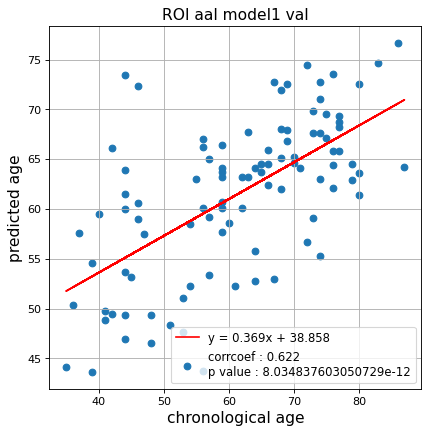

切片: 38.85816042838968
傾き: 0.36887026421394414
Let's use 4 GPUs!
Kfold: 4 ::: epoch: 100, loss: 0.037938923646624274, val loss: 1.1876865476369858
Kfold: 4 ::: epoch: 200, loss: 0.022735775233461306, val loss: 1.1324177384376526
Kfold: 4 ::: epoch: 300, loss: 0.013523735356732057, val loss: 1.0598335564136505
Kfold: 4 ::: epoch: 400, loss: 0.009319589652407628, val loss: 1.1239220201969147
early stopping
save_epochs:220
best val loss:1.059114322066307


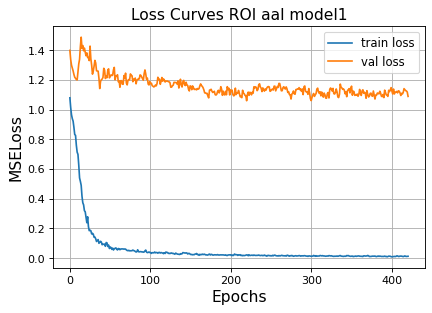

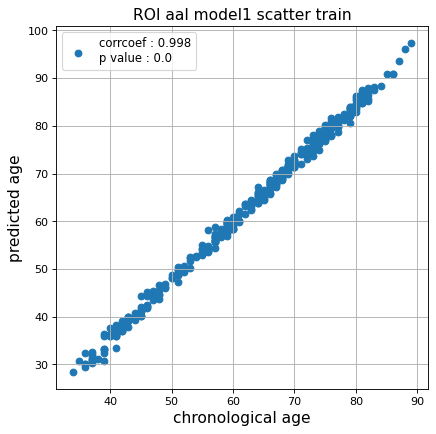

r^2 train data:  0.941141929422261


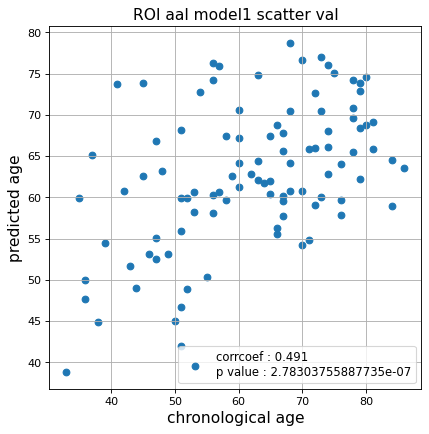

r^2 val data:  0.21620573563229062


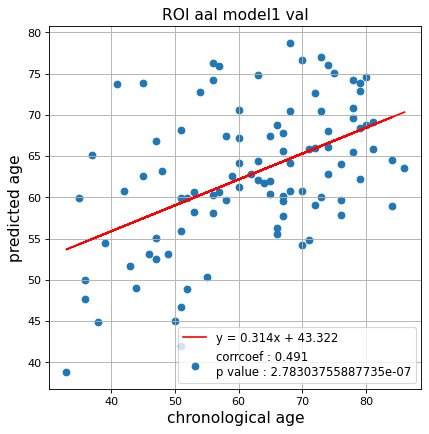

切片: 43.32169209351658
傾き: 0.3141464128526986
Let's use 4 GPUs!
Kfold: 5 ::: epoch: 100, loss: 0.04261991653877955, val loss: 0.9421249777078629
Kfold: 5 ::: epoch: 200, loss: 0.024639033139325105, val loss: 0.7836601287126541
Kfold: 5 ::: epoch: 300, loss: 0.014615460406415738, val loss: 0.7162796929478645
Kfold: 5 ::: epoch: 400, loss: 0.013218716646616276, val loss: 0.6894757077097893
Kfold: 5 ::: epoch: 500, loss: 0.011304582899006514, val loss: 0.6697221994400024
Kfold: 5 ::: epoch: 600, loss: 0.009603043104736851, val loss: 0.6475777104496956
Kfold: 5 ::: epoch: 700, loss: 0.007785890681239275, val loss: 0.652062863111496
Kfold: 5 ::: epoch: 800, loss: 0.00660438656520385, val loss: 0.6431684568524361
early stopping


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.fc1.weight", "module.fc1.bias", "module.fc2.weight", "module.fc2.bias". 
	Unexpected key(s) in state_dict: "module.fc_age1.weight", "module.fc_age1.bias", "module.fc_sex1.weight", "module.fc_sex1.bias", "module.fc_age2.weight", "module.fc_age2.bias", "module.fc_sex2.weight", "module.fc_sex2.bias". 
	size mismatch for module.fc0.weight: copying a param with shape torch.Size([128, 116]) from checkpoint, the shape in current model is torch.Size([256, 116]).
	size mismatch for module.fc0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.pos.pe: copying a param with shape torch.Size([1, 5000, 128]) from checkpoint, the shape in current model is torch.Size([1, 5000, 256]).
	size mismatch for module.transformer_encoder_layer.self_attn.in_proj_weight: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for module.transformer_encoder_layer.self_attn.in_proj_bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for module.transformer_encoder_layer.self_attn.out_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for module.transformer_encoder_layer.self_attn.out_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder_layer.linear1.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for module.transformer_encoder_layer.linear1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for module.transformer_encoder_layer.linear2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for module.transformer_encoder_layer.linear2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder_layer.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder_layer.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder_layer.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder_layer.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for module.transformer_encoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for module.transformer_encoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for module.transformer_encoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for module.transformer_encoder.layers.0.linear1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for module.transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for module.transformer_encoder.layers.0.linear2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for module.transformer_encoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for module.transformer_encoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for module.transformer_encoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.linear1.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for module.transformer_encoder.layers.1.linear1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for module.transformer_encoder.layers.1.linear2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 1024]).
	size mismatch for module.transformer_encoder.layers.1.linear2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for module.transformer_encoder.layers.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).

In [16]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_1  = []
test_pred_aal_corrected_1  = []
test_label_aal_1 = []
test_idx_aal_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model1'
                                                          )
    
    test_pred_aal_1.append(test_pred)
    test_pred_aal_corrected_1.append(test_pred_corrected)
    test_label_aal_1.append(test_label)
    test_idx_aal_1.append(test_idx)

### ROI 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_2  = []
test_pred_aal_corrected_2  = []
test_label_aal_2 = []
test_idx_aal_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI aal model2'
                                                          )
    
    test_pred_aal_2.append(test_pred)
    test_pred_aal_corrected_2.append(test_pred_corrected)
    test_label_aal_2.append(test_label)
    test_idx_aal_2.append(test_idx)

Nested Kfold ::: 1
Let's use 4 GPUs!
Kfold: 1 ::: epoch: 100, loss: 0.05412113845634919, val loss: 0.8152643591165543
Kfold: 1 ::: epoch: 200, loss: 0.029152244616013307, val loss: 0.7702676206827164
Kfold: 1 ::: epoch: 300, loss: 0.026699254289269447, val loss: 0.7161850184202194
Kfold: 1 ::: epoch: 400, loss: 0.01990157888772396, val loss: 0.6700850576162338
Kfold: 1 ::: epoch: 500, loss: 0.016294261512274925, val loss: 0.6631455048918724
Kfold: 1 ::: epoch: 600, loss: 0.01442418354921616, val loss: 0.6464804708957672


### データ保存

In [ ]:
test_pred_aal_1 = np.array(test_pred_aal_1, dtype=object)
test_pred_aal_corrected_1 = np.array(test_pred_aal_corrected_1, dtype=object)

test_pred_aal_2 = np.array(test_pred_aal_2, dtype=object)
test_pred_aal_corrected_2 = np.array(test_pred_aal_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/aal_1',
         test_pred_aal_1,
         test_pred_aal_corrected_1,
         test_label_aal_1,
         test_idx_aal_1)
np.savez('../02_data_analysis/temp/aal_2',
         test_pred_aal_2,
         test_pred_aal_corrected_2,
         test_label_aal_2,
         test_idx_aal_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_aal = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_aal.csv')
data_dynamic_aal = make_data(df_dynamic_aal)
print(data_dynamic_aal.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_1  = []
test_pred_aal_dynamic_corrected_1  = []
test_label_aal_dynamic_1 = []
test_idx_aal_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop   = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model1'
                                                          )
    
    test_pred_aal_dynamic_1.append(test_pred)
    test_pred_aal_dynamic_corrected_1.append(test_pred_corrected)
    test_label_aal_dynamic_1.append(test_label)
    test_idx_aal_dynamic_1.append(test_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_aal_dynamic_2  = []
test_pred_aal_dynamic_corrected_2  = []
test_label_aal_dynamic_2 = []
test_idx_aal_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_aal)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_aal,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC aal model2'
                                                          )
    
    test_pred_aal_dynamic_2.append(test_pred)
    test_pred_aal_dynamic_corrected_2.append(test_pred_corrected)
    test_label_aal_dynamic_2.append(test_label)
    test_idx_aal_dynamic_2.append(test_idx)

### データ保存

In [ ]:
test_pred_aal_dynamic_1 = np.array(test_pred_aal_dynamic_1, dtype=object)
test_pred_aal_dynamic_corrected_1 = np.array(test_pred_aal_dynamic_corrected_1, dtype=object)

test_pred_aal_dynamic_2 = np.array(test_pred_aal_dynamic_2, dtype=object)
test_pred_aal_dynamic_corrected_2 = np.array(test_pred_aal_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_aal_1',
         test_pred_aal_dynamic_1,
         test_pred_aal_dynamic_corrected_1,
         test_label_aal_dynamic_1,
         test_idx_aal_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_aal_2',
         test_pred_aal_dynamic_2,
         test_pred_aal_dynamic_corrected_2,
         test_label_aal_dynamic_2,
         test_idx_aal_dynamic_2)

## 学習(Harvard-Oxford)

### ROI 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_1  = []
test_pred_ho_corrected_1  = []
test_label_ho_1 = []
test_idx_ho_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 256,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 1024,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.2,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model1'
                                                          )
    
    test_pred_ho_1.append(test_pred)
    test_pred_ho_corrected_1.append(test_pred_corrected)
    test_label_ho_1.append(test_label)
    test_idx_ho_1.append(test_idx)

### ROI 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_2  = []
test_pred_ho_corrected_2  = []
test_label_ho_2 = []
test_idx_ho_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 1000,
                                                           d_model    = 128,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 128,
                                                           nhead      = 32,
                                                           hidden_dim_transformer = 2,
                                                           pos_drop    = 0.1,
                                                           trans_drop = 0.1,
                                                           fc_drop = 0.1,
                                                           title = 'ROI ho model2'
                                                          )
    
    test_pred_ho_2.append(test_pred)
    test_pred_ho_corrected_2.append(test_pred_corrected)
    test_label_ho_2.append(test_label)
    test_idx_ho_2.append(test_idx)

### データ保存

In [ ]:
test_pred_ho_1 = np.array(test_pred_ho_1, dtype=object)
test_pred_ho_corrected_1 = np.array(test_pred_ho_corrected_1, dtype=object)

test_pred_ho_2 = np.array(test_pred_ho_2, dtype=object)
test_pred_ho_corrected_2 = np.array(test_pred_ho_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/ho_1',
         test_pred_ho_1,
         test_pred_ho_corrected_1,
         test_label_ho_1,
         test_idx_ho_1)
np.savez('../02_data_analysis/temp/ho_2',
         test_pred_ho_2,
         test_pred_ho_corrected_2,
         test_label_ho_2,
         test_idx_ho_2)

### Data定義(dynamic FC)

In [ ]:
%%time
df_dynamic_ho = pd.read_csv('../02_data_analysis/dynamic_FC/dynamic_ho.csv')
data_dynamic_ho = make_data(df_dynamic_ho)
print(data_dynamic_ho.shape)

### Dynamic FC 1

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_1  = []
test_pred_ho_dynamic_corrected_1  = []
test_label_ho_dynamic_1 = []
test_idx_ho_dynamic_1   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.3,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model1'
                                                          )
    
    test_pred_ho_dynamic_1.append(test_pred)
    test_pred_ho_dynamic_corrected_1.append(test_pred_corrected)
    test_label_ho_dynamic_1.append(test_label)
    test_idx_ho_dynamic_1.append(test_idx)

### Dynamic FC 2

In [ ]:
%%time
fold = KFold(n_splits=n_splits,shuffle=False)

test_pred_ho_dynamic_2  = []
test_pred_ho_dynamic_corrected_2  = []
test_label_ho_dynamic_2 = []
test_idx_ho_dynamic_2   = []

for fold_idx, (train_idx, test_idx) in enumerate(fold.split(data_ho)):
    print(f'Nested Kfold ::: {fold_idx+1}')
    test_pred,test_pred_corrected,test_label = train_model(data_dynamic_ho,
                                                           data_label,
                                                           train_idx  = train_idx,
                                                           test_idx   = test_idx,
                                                           epochs     = 700,
                                                           d_model    = 64,
                                                           n_splits   = n_splits,
                                                           hidden_dim = 256,
                                                           nhead      = 2,#4
                                                           hidden_dim_transformer = 1,#2
                                                           pos_drop    = 0.5,
                                                           trans_drop = 0.5,
                                                           fc_drop = 0.3,
                                                           title = 'DynamicFC ho model2'
                                                          )
    
    test_pred_ho_dynamic_2.append(test_pred)
    test_pred_ho_dynamic_corrected_2.append(test_pred_corrected)
    test_label_ho_dynamic_2.append(test_label)
    test_idx_ho_dynamic_2.append(test_idx)

### データ保存

In [ ]:
test_pred_ho_dynamic_1 = np.array(test_pred_ho_dynamic_1, dtype=object)
test_pred_ho_dynamic_corrected_1 = np.array(test_pred_ho_dynamic_corrected_1, dtype=object)

test_pred_ho_dynamic_2 = np.array(test_pred_ho_dynamic_2, dtype=object)
test_pred_ho_dynamic_corrected_2 = np.array(test_pred_ho_dynamic_corrected_2, dtype=object)

In [ ]:
np.savez('../02_data_analysis/temp/dynamic_ho_1',
         test_pred_ho_dynamic_1,
         test_pred_ho_dynamic_corrected_1,
         test_label_ho_dynamic_1,
         test_idx_ho_dynamic_1)
np.savez('../02_data_analysis/temp/dynamic_ho_2',
         test_pred_ho_dynamic_2,
         test_pred_ho_dynamic_corrected_2,
         test_label_ho_dynamic_2,
         test_idx_ho_dynamic_2)